The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ T^{0\nu\beta\beta}_{1/2}|_{\text{low}}  = \text{log}(2) t \frac{\epsilon_s}{S(b)} N_0$$

$$ S(T^{0\nu\beta\beta}_{1/2}) \propto \epsilon_s \sqrt{\frac{t \cdot M}{b \cdot \Delta E}}$$

In the large background approximation: $S(b) = \alpha(\text{C.L.})\sqrt{b}$


The sensitivity of a $0\nu\beta\beta$ experiment is proportional to the value
$$\text{figure of merit} = \frac{\epsilon_s}{\sqrt{\epsilon_b}}$$
were $\epsilon_{s, b}$ are the selection efficiencies for signal and background after the selection cuts.

If no cuts are applied, the figure of merit is 1, therefore any cut that improves sensitivity must fullfil
$$\frac{\epsilon_s}{\sqrt{\epsilon_b}} > 1 $$

In [19]:
import os
import sys
import time
import glob
import tables as tb
import pandas as pd
import numpy  as np

from itertools import combinations

from invisible_cities.core.system_of_units import kg, year, day, mBq, m3, mm, cm, m, s
dalton = 1.660539e-27 * kg
#from invisible_cities.evm.mixer            import get_file_number
get_file_number = lambda filename: int(filename.split("/")[-1].split(".h5")[0].split("_")[1])


from invisible_cities.io.dst_io            import load_dst, load_dsts
from invisible_cities.database.load_db     import RadioactivityData

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = False

In [2]:
def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [3]:
basedir = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/analysis/'

In [4]:
# activities
act_df, _ = RadioactivityData("next100")
flux  = 0.78 * 5.26e-3 /(m**2 * s)

# # new activities
# filename = "NEXT100_newcopper.ods"
# df = pd.read_excel(filename, sheet_name=" DB  ACTIVITIES")
# df = df.drop(["Unnamed: 1", "Co-60", "K-40", "NEXT100 TOTAL ACTIVITIES FOR DB"], axis=1)
# df = df.rename({"NEXUS VOLUME": "G4Volume", "Bi-214": "214Bi", "Tl-208": "208Tl"}, axis=1)
# df = pd.melt(df, id_vars="G4Volume", value_vars=["208Tl", "214Bi"])
# df = df.rename({"variable": "Isotope", "value": "TotalActivity"}, axis=1)
# # df = df.set_index(index)
# act_df = df

# efficiencies
eff_df = pd.read_csv(basedir + "efficiencies_2.4_2.5_MeV.csv")

R = 7.64 * m
theta =  np.arctan(R / (86 * cm + 207.6 * cm))
A     = (2.*np.pi-theta) * R * (5.0 * m)
muon_activity = flux * A /mBq
act_df.loc[len(act_df)] = ("LAB_WALLS", "muons", muon_activity)           # muon flux (in mBq)
act_df.loc[len(act_df)] = (   "ACTIVE", "137Xe", muon_activity*3.965e-05) # x Xe137 per muon

# simulated exposure
index = ["Isotope", "G4Volume"]
act_df = act_df.set_index(index)
eff_df = eff_df.set_index(index)

# dummy exposure for 0nubb
eff_df["exposure"] = eff_df.nsim / (act_df.TotalActivity * mBq) /year
eff_df.loc[("0nubb", "ACTIVE"), "exposure"] = 100

In [5]:
enrichment = 0.9
xenon_density = 78.949 * kg/m3
volume        = np.pi*(490*mm)**2*1200*mm
xenon_mass = (xenon_density * volume)
N0 = enrichment*(xenon_mass/(136. * dalton))

T12_0nubb = (N0 * np.log(2) * eff_df.loc[("0nubb", "ACTIVE"), "exposure"]) / eff_df.loc[("0nubb", "ACTIVE")].nsim

print("simulated 0nubb half-life (years):", T12_0nubb)

simulated 0nubb half-life (years): 1.316008320847196e+24


In [6]:
analysis_filename = basedir + "tracks_2.4_2.5_MeV.h5"

tracks_0nubb = pd.read_hdf(analysis_filename, "0nubb").set_index(["event", "file"])
tracks_214Bi = pd.read_hdf(analysis_filename, "214Bi").set_index(["event", "file"])
tracks_208Tl = pd.read_hdf(analysis_filename, "208Tl").set_index(["event", "file"])
tracks_muons = pd.read_hdf(analysis_filename, "muons").set_index(["event", "file"])
tracks_137Xe = pd.read_hdf(analysis_filename, "137Xe").set_index(["event", "file"])

In [7]:
spurious_energy = 0.01

# remove spurious
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)
tracks_muons = remove_spurious_tracks(tracks_muons, spurious_energy)
tracks_137Xe = remove_spurious_tracks(tracks_137Xe, spurious_energy)

In [8]:
# add exposures to normalice each G4Volume contribution in further analysis

tracks_208Tl.reset_index(inplace=True)
tracks_214Bi.reset_index(inplace=True)
tracks_muons.reset_index(inplace=True)
tracks_137Xe.reset_index(inplace=True)

tracks_208Tl.set_index("G4Volume", inplace=True)
tracks_214Bi.set_index("G4Volume", inplace=True)
tracks_muons.set_index("G4Volume", inplace=True)
tracks_137Xe.set_index("G4Volume", inplace=True)

tracks_208Tl.loc[:, "exposure"] = eff_df.loc["208Tl"].exposure
tracks_214Bi.loc[:, "exposure"] = eff_df.loc["214Bi"].exposure
tracks_muons.loc[:, "exposure"] = eff_df.loc["muons"].exposure
tracks_137Xe.loc[:, "exposure"] = eff_df.loc["137Xe"].exposure

tracks_208Tl.reset_index(inplace=True)
tracks_214Bi.reset_index(inplace=True)
tracks_muons.reset_index(inplace=True)
tracks_137Xe.reset_index(inplace=True)

tracks_208Tl.set_index(["event", "file"], inplace=True)
tracks_214Bi.set_index(["event", "file"], inplace=True)
tracks_muons.set_index(["event", "file"], inplace=True)
tracks_137Xe.set_index(["event", "file"], inplace=True)

In [9]:
# number of events after each cut for backgrounds
selections = [ "nsim"
             , "nexus"
             , "reco"
             , "energy"
             , "fiducial"
             , "track"
             , "overlap"
             , "ROI"
             , "topo"]

selections_df = pd.DataFrame(columns=selections)
selections_df.loc[:,   "nsim"] = (eff_df.nsim    /eff_df.exposure).groupby(level=0).sum()
selections_df.loc[:,  "nexus"] = (eff_df.nsaved  /eff_df.exposure).groupby(level=0).sum()
selections_df.loc[:,   "reco"] = (eff_df.npass   /eff_df.exposure).groupby(level=0).sum()
selections_df.loc[:, "energy"] = (eff_df.nenergy /eff_df.exposure).groupby(level=0).sum()

# 0nubb efficiency w.r.t all energy
selections_df.loc["0nubb", "nexus"] = eff_df.loc[("0nubb", "ACTIVE")].nsim / \
                                      eff_df.loc[("0nubb", "ACTIVE")].exposure

In [10]:
# number of events after each cut for backgrounds
selections = [ "nsim"
             , "nexus"
             , "reco"
             , "energy"
             , "fiducial"
             , "track"
             , "overlap"
             , "ROI"
             , "topo"]

selections_df_abs = pd.DataFrame(columns=selections)
selections_df_abs.loc[:,  "nsim"]  = eff_df.nsim
selections_df_abs.loc[:,  "nexus"] = eff_df.nsaved
selections_df_abs.loc[:,   "reco"] = eff_df.npass
selections_df_abs.loc[:, "energy"] = eff_df.nenergy

# 0nubb efficiency w.r.t all energy
selections_df_abs.loc["0nubb", "nexus"] = eff_df.loc[("0nubb", "ACTIVE")].nsim
# selections_df_abs.fillna(0., inplace=True)
#selections_df_abs.sort_index(inplace=True)

## Fiducialization

Efficiency: 0.9272746353237485


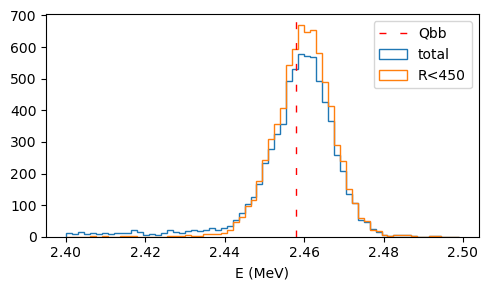

In [27]:
plt.figure(figsize=[5, 3])

rmax = 450
zmin = 20
zmax = 1180

bins = np.arange(2.40, 2.50, 0.0015)

plt.hist(tracks_0nubb.energy, bins=bins, histtype="step", label="total")

sel = (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max < zmax)
print("Efficiency:", sel.sum()/tracks_0nubb.index.size)

plt.hist( tracks_0nubb.loc[sel].groupby(level=[0,1]).energy.sum()
        , bins=bins, histtype="step", label=f"R<{rmax}")
Qbb = 2.458
plt.axvline(Qbb, c="r", linewidth=1, linestyle=(0, (5, 10)), label="Qbb")
plt.xlabel("E (MeV)")

plt.legend()
plt.tight_layout();

In [30]:
rmax = 450
zmin = 20
zmax = 1180

# 0nubb
sel_0nubb = (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max<zmax)
rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df    .loc["0nubb", "fiducial"] = rate
selections_df_abs.loc["0nubb", "fiducial"] = tracks_0nubb.loc[sel_0nubb].index.nunique()

# 214Bi
sel_214Bi = (tracks_214Bi.r_max < rmax) & (zmin<tracks_214Bi.z_min) & (tracks_214Bi.z_max<zmax)
rate = (tracks_214Bi.loc[sel_214Bi].groupby("G4Volume").apply(lambda df: df.index.nunique()) / eff_df.loc["214Bi"].exposure).sum()
selections_df    .loc["214Bi", "fiducial"] = rate
s = tracks_214Bi.loc[sel_214Bi].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["214Bi", "fiducial"] = pd.Series(selections_df_abs.loc["214Bi"].index).map(s).values

# 208Tl
sel_208Tl = (tracks_208Tl.r_max < rmax) & (zmin<tracks_208Tl.z_min) & (tracks_208Tl.z_max<zmax)
rate = (tracks_208Tl.loc[sel_208Tl].groupby("G4Volume").apply(lambda df: df.index.nunique()) / eff_df.loc["208Tl"].exposure).sum()
selections_df    .loc["208Tl", "fiducial"] = rate
s = tracks_208Tl.loc[sel_208Tl].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["208Tl", "fiducial"] = pd.Series(selections_df_abs.loc["208Tl"].index).map(s).values

# muons
sel_muons = (tracks_muons.r_max < rmax) & (zmin<tracks_muons.z_min) & (tracks_muons.z_max<zmax)
rate = (tracks_muons.loc[sel_muons].groupby("G4Volume").apply(lambda df: df.index.nunique()) / eff_df.loc["muons"].exposure).sum()
selections_df.loc    ["muons", "fiducial"] = rate
selections_df_abs.loc["muons", "fiducial"] = tracks_muons.loc[sel_muons].index.nunique()

# 137Xe
sel_137Xe = (tracks_137Xe.r_max < rmax) & (zmin<tracks_137Xe.z_min) & (tracks_137Xe.z_max<zmax)
rate = (tracks_137Xe.loc[sel_137Xe].groupby("G4Volume").apply(lambda df: df.index.nunique()) / eff_df.loc["137Xe"].exposure).sum()
selections_df    .loc["137Xe", "fiducial"] = rate
selections_df_abs.loc["137Xe", "fiducial"] = tracks_137Xe.loc[sel_137Xe].index.nunique()

es = selections_df.loc["0nubb"].fiducial/selections_df.loc["0nubb"].energy
bk = ("208Tl", "214Bi", "muons", "137Xe")
eb = selections_df.loc[bk, :].fiducial.sum()/selections_df.loc[bk, :].energy.sum()
 
print(f"fiducial cut: fom =", round(es/np.sqrt(eb), 2))

fiducial cut: fom = 0.99


In [32]:
print("fiducial selection efficiency")
print("----------------------------")
selections_df.fiducial/selections_df.energy

fiducial selection efficiency
----------------------------


Isotope
0nubb    0.929874
137Xe     0.84382
208Tl    0.873231
214Bi    0.931494
muons    0.847539
dtype: object

## Track multiplicity

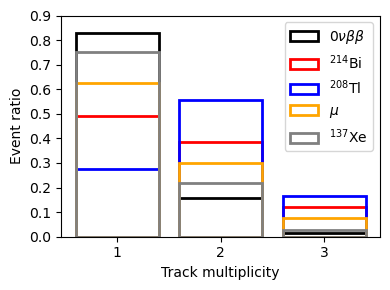

In [33]:
plt.figure(figsize=[4, 3])

bins = np.arange(0.5, 4.5, 1)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram( tracks_0nubb.loc[sel_0nubb].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$0\nu\beta\beta$", color="none", edgecolor="k", linewidth=2)

# background
h, _ = np.histogram( tracks_214Bi.loc[sel_214Bi].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_214Bi.loc[sel_214Bi].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$^{214}$Bi", color="none", edgecolor="r", linewidth=2)

h, _ = np.histogram( tracks_208Tl.loc[sel_208Tl].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_208Tl.loc[sel_208Tl].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$^{208}$Tl", color="none", edgecolor="b", linewidth=2)

h, _ = np.histogram( tracks_muons.loc[sel_muons].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_muons.loc[sel_muons].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$\mu$", color="none", edgecolor="orange", linewidth=2)

h, _ = np.histogram( tracks_137Xe.loc[sel_137Xe].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_137Xe.loc[sel_137Xe].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$^{137}$Xe", color="none", edgecolor="grey", linewidth=2)

plt.legend()
plt.ylabel("Event ratio")
plt.xlabel("Track multiplicity")
plt.xticks(binc)
plt.yticks(np.arange(0, 1, 0.1))
plt.tight_layout()

In [45]:
# ntracks = 1
n = 1

sel  = sel_0nubb & (tracks_0nubb.numb_of_tracks <= n)
rate = (tracks_0nubb.loc[sel].index.nunique() / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df    .loc["0nubb", "track"] = rate
selections_df_abs.loc["0nubb", "track"] = tracks_0nubb.loc[sel].index.nunique()

# 214Bi
sel  = sel_214Bi & (tracks_214Bi.numb_of_tracks <= n)
rate = (tracks_214Bi.loc[sel].value_counts("G4Volume") / eff_df.loc["214Bi"].exposure).sum()
selections_df    .loc["214Bi", "track"] = rate
s = tracks_214Bi.loc[sel].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["214Bi", "track"] = pd.Series(selections_df_abs.loc["214Bi"].index).map(s).values

# 208Tl
sel  = sel_208Tl & (tracks_208Tl.numb_of_tracks <= n)
rate = (tracks_208Tl.loc[sel].value_counts("G4Volume") / eff_df.loc["208Tl"].exposure).sum()
selections_df    .loc["208Tl", "track"] = rate
s = tracks_208Tl.loc[sel].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["208Tl", "track"] = pd.Series(selections_df_abs.loc["208Tl"].index).map(s).values

# muons
sel  = sel_muons & (tracks_muons.numb_of_tracks <= n)
rate = (tracks_muons.loc[sel].value_counts("G4Volume") / eff_df.loc["muons"].exposure).sum()
selections_df    .loc["muons", "track"] = rate
selections_df_abs.loc["muons", "track"] = tracks_muons.loc[sel].index.nunique()

# 137Xe
sel  = sel_137Xe & (tracks_137Xe.numb_of_tracks <= n)
rate = (tracks_137Xe.loc[sel].value_counts("G4Volume") / eff_df.loc["137Xe"].exposure).sum()
selections_df    .loc["137Xe", "track"] = rate
selections_df_abs.loc["137Xe", "track"] = tracks_137Xe.loc[sel].index.nunique()

es = selections_df.loc["0nubb"].track/selections_df.loc["0nubb"].fiducial
bk = ("208Tl", "214Bi", "muons", "137Xe")
eb = selections_df.loc[bk, :].track.sum()/selections_df.loc[bk, :].fiducial.sum()

print(f"ntracks <= {n} cut: fom =", round(es/np.sqrt(eb), 2))

ntracks <= 1 cut: fom = 1.49


In [46]:
print("1 track selection efficiency")
print("----------------------------")
selections_df.track/selections_df.fiducial

1 track selection efficiency
----------------------------


Isotope
0nubb    0.828893
137Xe    0.748668
208Tl    0.275973
214Bi     0.48307
muons    0.610482
dtype: object

In [48]:
# selection dfs
sel_0nubb = sel_0nubb & (tracks_0nubb.numb_of_tracks == 1)
sel_208Tl = sel_208Tl & (tracks_208Tl.numb_of_tracks == 1)
sel_214Bi = sel_214Bi & (tracks_214Bi.numb_of_tracks == 1)
sel_muons = sel_muons & (tracks_muons.numb_of_tracks == 1)
sel_137Xe = sel_137Xe & (tracks_137Xe.numb_of_tracks == 1)

## Overlap, ROI and $E_{b_2}$

In [49]:
sel_0nubb = sel_0nubb & (tracks_0nubb.ovlp_blob_energy == 0)
sel_214Bi = sel_214Bi & (tracks_214Bi.ovlp_blob_energy == 0)
sel_208Tl = sel_208Tl & (tracks_208Tl.ovlp_blob_energy == 0)
sel_muons = sel_muons & (tracks_muons.ovlp_blob_energy == 0)
sel_137Xe = sel_137Xe & (tracks_137Xe.ovlp_blob_energy == 0)

rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df    .loc["0nubb", "overlap"] = rate
selections_df_abs.loc["0nubb", "overlap"] = tracks_0nubb.loc[sel_0nubb].index.nunique()

# 214Bi
rate = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / eff_df.loc["214Bi"].exposure).sum()
selections_df    .loc["214Bi", "overlap"] = rate
s = tracks_214Bi.loc[sel_214Bi].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["214Bi", "overlap"] = pd.Series(selections_df_abs.loc["214Bi"].index).map(s).values

# 208Tl
rate = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / eff_df.loc["208Tl"].exposure).sum()
selections_df    .loc["208Tl", "overlap"] = rate
s = tracks_208Tl.loc[sel_208Tl].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["208Tl", "overlap"] = pd.Series(selections_df_abs.loc["208Tl"].index).map(s).values

# muons
rate = (tracks_muons.loc[sel_muons].value_counts("G4Volume") / eff_df.loc["muons"].exposure).sum()
selections_df    .loc["muons", "overlap"] = rate
selections_df_abs.loc["muons", "overlap"] = tracks_muons.loc[sel_muons].index.nunique()

# 137Xe
rate = (tracks_137Xe.loc[sel_137Xe].value_counts("G4Volume") / eff_df.loc["137Xe"].exposure).sum()
selections_df    .loc["137Xe", "overlap"] = rate
selections_df_abs.loc["137Xe", "overlap"] = tracks_137Xe.loc[sel_137Xe].index.nunique()

# es = selections_df.loc["0nubb"].overlap/selections_df.loc["0nubb"].track
# eb = selections_df.loc[("208Tl", "214Bi"), :].overlap.sum()/selections_df.loc[("208Tl", "214Bi"), :].track.sum()

# no overlap
print("No overlap between blobs efficiencies:")
print("-------------------------------------")
selections_df.overlap / selections_df.track

No overlap between blobs efficiencies:
-------------------------------------


Isotope
0nubb    0.981612
137Xe    0.996888
208Tl    0.996396
214Bi    0.996335
muons     0.99536
dtype: object

In [51]:
ROI = np.arange(2.42, 2.50, 0.002)
combs = list(combinations(ROI, 2))

R.O.I (2.453999999999996, 2.471999999999994)
f.o.m: 2.026469021531959


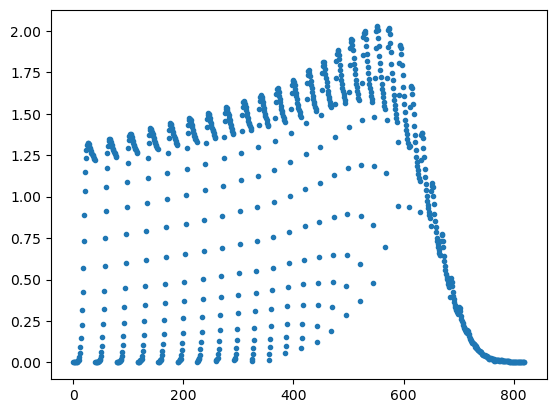

In [126]:
ROI = np.arange(2.42, 2.50, 0.002)
combs = list(combinations(ROI, 2))

ns  = []
nb1 = []
nb2 = []
nb3 = []
nb4 = []
for i, comb in enumerate(combs):
    emin, emax = comb
    st  = tracks_0nubb.loc[sel_0nubb & tracks_0nubb.energy.between(emin, emax)]
    bt1 = tracks_208Tl.loc[sel_208Tl & tracks_208Tl.energy.between(emin, emax)]
    bt2 = tracks_214Bi.loc[sel_214Bi & tracks_214Bi.energy.between(emin, emax)]
    bt3 = tracks_muons.loc[sel_muons & tracks_muons.energy.between(emin, emax)]
    bt4 = tracks_137Xe.loc[sel_137Xe & tracks_137Xe.energy.between(emin, emax)]
    
    ns .append(( st.value_counts("G4Volume") / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum())
    nb1.append((bt1.value_counts("G4Volume") / eff_df.loc["208Tl"]            .exposure).sum())
    nb2.append((bt2.value_counts("G4Volume") / eff_df.loc["214Bi"]            .exposure).sum())
    nb3.append((bt3.value_counts("G4Volume") / eff_df.loc["muons"]            .exposure).sum())
    nb4.append((bt4.value_counts("G4Volume") / eff_df.loc["137Xe"]            .exposure).sum())
    
ns = np.array(ns)
nb = np.array(nb1) + np.array(nb2) + np.array(nb3) + np.array(nb4)

foms =        (ns/selections_df.loc["0nubb", "overlap"]) / \
       np.sqrt(nb/selections_df.loc[("208Tl", "214Bi", "muons", "137Xe"), :].overlap.sum())

roi = combs[np.argmax(foms)]

print( "R.O.I", roi)
print("f.o.m:", np.max(foms))

plt.plot(foms, '.')

In [125]:
#selecting the max fom per roi inverval
values = np.unique([a[0] for a in combs])

fom_selection = [[np.isclose(v, i).any() for i in combs] for v in values]

roi_max_fom = [np.array(combs)[mask][np.argmax(foms[mask])] for mask in fom_selection]
max_fom = [np.max(foms[mask]) for mask in fom_selection]

In [129]:
#here we select the rate from the calculation above bc all the rates were already calculated for several ROIs
#but it should match picking the tracks_ df and using the selected ROI to choose the tracks

selections_df.loc["0nubb", "ROI"] = ns [np.argmax(foms)]
selections_df.loc["208Tl", "ROI"] = nb1[np.argmax(foms)]
selections_df.loc["214Bi", "ROI"] = nb2[np.argmax(foms)]
selections_df.loc["muons", "ROI"] = nb3[np.argmax(foms)]
selections_df.loc["137Xe", "ROI"] = nb4[np.argmax(foms)]

# 0nubb
sel = sel_0nubb & tracks_0nubb.energy.between(*roi)
selections_df_abs.loc["0nubb", "ROI"] = tracks_0nubb.loc[sel].index.nunique()

# 214Bi
sel = sel_214Bi & tracks_214Bi.energy.between(*roi)
s = tracks_214Bi.loc[sel].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["214Bi", "ROI"] = pd.Series(selections_df_abs.loc["214Bi"].index).map(s).values

# 208Tl
sel = sel_208Tl & tracks_208Tl.energy.between(*roi)
s = tracks_208Tl.loc[sel].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["208Tl", "ROI"] = pd.Series(selections_df_abs.loc["208Tl"].index).map(s).values

# muons
sel = sel_muons & tracks_muons.energy.between(*roi)
selections_df_abs.loc["muons", "ROI"] = tracks_muons.loc[sel].index.nunique()

# 137Xe
sel = sel_137Xe & tracks_137Xe.energy.between(*roi)
selections_df_abs.loc["137Xe", "ROI"] = tracks_137Xe.loc[sel].index.nunique()

print("ROI selection efficiencies:")
print("--------------------------")
selections_df.ROI / selections_df.overlap

ROI selection efficiencies:
--------------------------


Isotope
0nubb     0.76071
137Xe    0.173506
208Tl    0.121058
214Bi    0.229466
muons    0.191142
dtype: object

ROI (MeV): (2.453999999999996, 2.471999999999994)


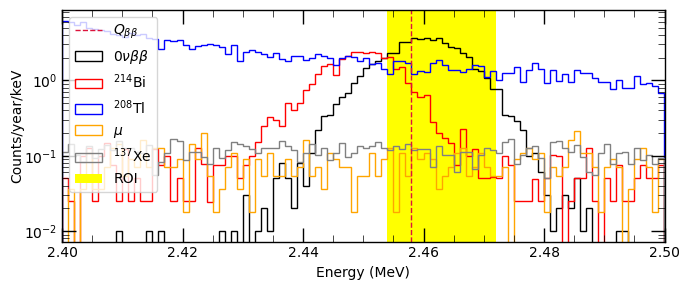

In [168]:
fig = plt.figure(figsize=[7, 3])
ax = fig.add_subplot(111)

bins = np.arange(2.40, 2.50, 0.001)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram( tracks_0nubb.loc[sel_0nubb].energy, bins=bins
                   , weights=np.ones(sel_0nubb.sum())/eff_df.loc[("0nubb", "ACTIVE")].exposure)
ax.stairs(h, bins, label=r"$0\nu\beta\beta$", facecolor="none", edgecolor="k", fill=True)

# 214Bi
h, _ = np.histogram( tracks_214Bi.loc[sel_214Bi].energy, bins=bins
         , weights=1/tracks_214Bi.loc[sel_214Bi].exposure)
ax.stairs(h, bins, label=r"$^{214}$Bi", facecolor="none", edgecolor="r", alpha=1.0, fill=True)


# 208Tl
h, _ = np.histogram( tracks_208Tl.loc[sel_208Tl].energy, bins=bins
         , weights=1/tracks_208Tl.loc[sel_208Tl].exposure)
ax.stairs(h, bins, label=r"$^{208}$Tl", facecolor="none", edgecolor="b", alpha=1.0, fill=True)


# muons
h, _ = np.histogram( tracks_muons.loc[sel_muons].energy, bins=bins
         , weights=1/tracks_muons.loc[sel_muons].exposure)
ax.stairs(h, bins, label=r"$\mu$", facecolor="none", edgecolor="orange", alpha=1.0, fill=True)


# 137Xe
h, _ = np.histogram( tracks_137Xe.loc[sel_137Xe].energy, bins=bins
         , weights=1/tracks_137Xe.loc[sel_137Xe].exposure)
ax.stairs(h, bins, label=r"$^{137}$Xe", facecolor="none", edgecolor="grey", alpha=1.0, fill=True)

ax.set_yscale("log")

# ROI
Qbb = 2.458
plt.axvline(Qbb, c="crimson", linewidth=1, linestyle="--", label=r"$Q_{\beta\beta}$")
ax.set_ylim(ax.get_ylim())
ax.fill_betweenx(ax.get_ylim(), roi[0], roi[1], edgecolor="none", facecolor="yellow", label="ROI")

print("ROI (MeV):", roi)

# TICKS
ax.set_frame_on(True)
ax.tick_params(axis="both", which="major", direction="in", length=10, width=1,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.minorticks_on()
ax.tick_params(axis="both", which="minor", direction="in", length=5, width=0.5,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.spines["top"]   .set_linewidth(1)
ax.spines["left"]  .set_linewidth(1)
ax.spines["right"] .set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.set_ylabel("Counts/year/keV", labelpad=0)
ax.set_xlabel("Energy (MeV)")
ax.set_xlim([2.4, 2.5])
ax.legend(loc="upper left")
fig.tight_layout()

In [169]:
# figure of merit
Eb2s = np.arange(0, 1.0, 0.01)

ns  = []
nb1 = []
nb2 = []
nb3 = []
nb4 = []
for eb2 in Eb2s:
    emin, emax = comb
    st  = tracks_0nubb.loc[sel_0nubb & (eb2<tracks_0nubb.eblob2)]
    bt1 = tracks_208Tl.loc[sel_208Tl & (eb2<tracks_208Tl.eblob2)]
    bt2 = tracks_214Bi.loc[sel_214Bi & (eb2<tracks_214Bi.eblob2)]
    bt3 = tracks_muons.loc[sel_muons & (eb2<tracks_muons.eblob2)]
    bt4 = tracks_137Xe.loc[sel_137Xe & (eb2<tracks_137Xe.eblob2)]
    
    ns .append(( st.value_counts("G4Volume") / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum())
    nb1.append((bt1.value_counts("G4Volume") / eff_df.loc["208Tl"]            .exposure).sum())
    nb2.append((bt2.value_counts("G4Volume") / eff_df.loc["214Bi"]            .exposure).sum())
    nb3.append((bt3.value_counts("G4Volume") / eff_df.loc["muons"]            .exposure).sum())
    nb4.append((bt4.value_counts("G4Volume") / eff_df.loc["137Xe"]            .exposure).sum())
    
ns = np.array(ns)
nb = np.array(nb1) +  np.array(nb2) + np.array(nb3) + np.array(nb4)
#nb = np.array(nb1) +  np.array(nb2)                 + np.array(nb4)

es = ns/selections_df.loc["0nubb", "overlap"]
eb = nb/selections_df.loc[("208Tl", "214Bi", "muons", "137Xe"), :].overlap.sum()
# eb = nb/selections_df.loc[("208Tl", "214Bi",          "137Xe"), :].overlap.sum()

foms = es/np.sqrt(eb)
Eb2 = Eb2s[np.argmax(foms)]

print("Blob energy", Eb2)
print("f.o.m:", np.max(foms))

Blob energy 0.5700000000000001
f.o.m: 2.153621958787594


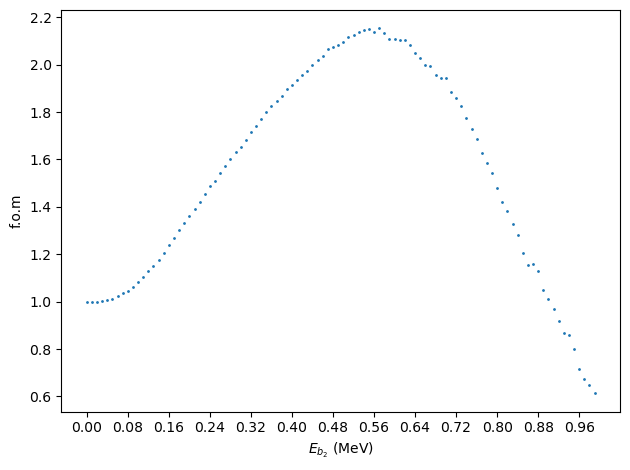

In [173]:
plt.figure()
plt.scatter(Eb2s, foms, s=1)
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.ylabel(r"f.o.m")
plt.xticks(Eb2s[::8])
plt.tight_layout()

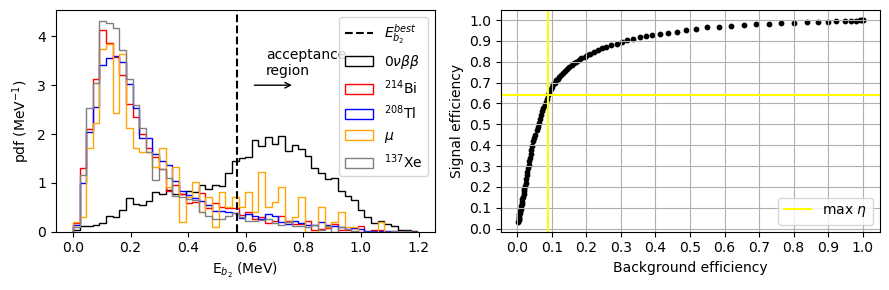

In [184]:
plt.figure(figsize=[9, 3])

bins = np.arange(0, 1.2, 0.023)
binc = (bins[1:] + bins[:-1])/2.

plt.subplot(121)
plt.hist( tracks_0nubb.loc[sel_0nubb].eblob2, bins=bins, histtype="step", color="k", label=r"$0\nu\beta\beta$"
        , weights=np.ones(sel_0nubb.sum())/eff_df.loc[("0nubb", "ACTIVE")].exposure, density=True)

plt.hist(           tracks_214Bi.loc[sel_214Bi].eblob2, bins=bins, histtype="step", color="r", label=r"$^{214}$Bi"
        , weights=1/tracks_214Bi.loc[sel_214Bi].exposure, density=True)

plt.hist(           tracks_208Tl.loc[sel_208Tl].eblob2, bins=bins, histtype="step", color="b", label=r"$^{208}$Tl"
        , weights=1/tracks_208Tl.loc[sel_208Tl].exposure, density=True)

plt.hist(           tracks_muons.loc[sel_muons].eblob2, bins=bins, histtype="step", color="orange", label=r"$\mu$"
        , weights=1/tracks_muons.loc[sel_muons].exposure, density=True)

plt.hist(           tracks_137Xe.loc[sel_137Xe].eblob2, bins=bins, histtype="step", color="grey", label=r"$^{137}$Xe"
        , weights=1/tracks_137Xe.loc[sel_137Xe].exposure, density=True)

plt.axvline(Eb2, color="k", linestyle="--", label=r"$E^{best}_{b_{2}}$")
plt.annotate("", xy=(Eb2+0.2, 3), xytext=(Eb2+0.05, 3), 
             arrowprops=dict(arrowstyle="->"))

plt.annotate("acceptance\nregion", xy=(0, 0), xytext=(Eb2+0.1, 3.2))

plt.ylabel(r"pdf (MeV$^{-1}$)")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

plt.subplot(122)
# plt.title("Efficiency evolution with $E_{b_2}$")

plt.scatter(eb, es, color="k", s=10)

plt.axhline(es[np.argmax(foms)], color="yellow", label=r"max $\eta$")
plt.axvline(eb[np.argmax(foms)], color="yellow")

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend()
plt.xlabel("Background efficiency")
plt.ylabel("Signal efficiency")
plt.tight_layout()

In [185]:
sel_0nubb = sel_0nubb & tracks_0nubb.energy.between(*roi) & (Eb2<tracks_0nubb.eblob2)
sel_208Tl = sel_208Tl & tracks_208Tl.energy.between(*roi) & (Eb2<tracks_208Tl.eblob2)
sel_214Bi = sel_214Bi & tracks_214Bi.energy.between(*roi) & (Eb2<tracks_214Bi.eblob2)
sel_muons = sel_muons & tracks_muons.energy.between(*roi) & (Eb2<tracks_muons.eblob2)
sel_137Xe = sel_137Xe & tracks_137Xe.energy.between(*roi) & (Eb2<tracks_137Xe.eblob2)

# 0nubb
rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / eff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df    .loc["0nubb", "topo"] = rate
selections_df_abs.loc["0nubb", "topo"] = tracks_0nubb.loc[sel_0nubb].index.nunique()

# 214Bi
rate = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / eff_df.loc["214Bi"].exposure).sum()
selections_df    .loc["214Bi", "topo"] = rate
s = tracks_214Bi.loc[sel_214Bi].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["214Bi", "topo"] = pd.Series(selections_df_abs.loc["214Bi"].index).map(s).values

# 208Tl
rate = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / eff_df.loc["208Tl"].exposure).sum()
selections_df    .loc["208Tl", "topo"] = rate
s = tracks_208Tl.loc[sel_208Tl].groupby("G4Volume").apply(lambda df: df.index.nunique())
selections_df_abs.loc["208Tl", "topo"] = pd.Series(selections_df_abs.loc["208Tl"].index).map(s).values

# muons
rate = (tracks_muons.loc[sel_muons].value_counts("G4Volume") / eff_df.loc["muons"].exposure).sum()
selections_df    .loc["muons", "topo"] = rate
selections_df_abs.loc["muons", "topo"] = tracks_muons.loc[sel_muons].index.nunique()

# 137Xe
rate = (tracks_137Xe.loc[sel_137Xe].value_counts("G4Volume") / eff_df.loc["137Xe"].exposure).sum()
selections_df    .loc["137Xe", "topo"] = rate
selections_df_abs.loc["137Xe", "topo"] = tracks_137Xe.loc[sel_137Xe].index.nunique()

# es = selections_df.loc["0nubb"].topo/selections_df.loc["0nubb"].ROI
# bk = ("208Tl", "214Bi", "muons", "137Xe")
# eb = selections_df.loc[bk, :].topo.sum()/selections_df.loc[bk, :].ROI.sum()

# print(f"fiducial cut: fom =", round(es/np.sqrt(eb), 2))

In [186]:
print("Total selection efficiencies E>2 MeV")
print("------------------------------------")
print(selections_df.topo / selections_df.nexus)
print()

signal_eff = (selections_df.topo / selections_df.nexus).loc["0nubb"]

background_rate = selections_df.loc[("208Tl", "214Bi", "muons"), :].topo.sum()
print("Total background rate (counts/year):", background_rate)

Total selection efficiencies E>2 MeV
------------------------------------
Isotope
0nubb    0.200133
137Xe    0.003276
208Tl    0.000408
214Bi     0.00277
muons    0.000358
dtype: object

Total background rate (counts/year): 3.4974648703508078


In [25]:
# add exposure, upperlimits and error
selections_df_abs.fillna(0., inplace=True)
selections_df_abs["exposure"] = eff_df.exposure

# ci_upper_lims = pd.read_csv("./feldman_cousins_db/fc_poisson_CIs.csv", index_col=0, header=[0, 1])

# selections_df_abs.reset_index(inplace=True)
# selections_df_abs.set_index("topo", inplace=True)
# selections_df_abs[ci_upper_lims.columns] = ci_upper_lims.loc[selections_df_abs.index.intersection(ci_upper_lims.index)]
# selections_df_abs.reset_index(inplace=True)
# selections_df_abs.set_index(["Isotope", "G4Volume"], inplace=True)

# selections_df_abs[("rate", "lo")] = (selections_df_abs[("68.2", "lo")] / selections_df_abs.exposure)
# selections_df_abs[("rate", "up")] = (selections_df_abs[("68.2", "up")] / selections_df_abs.exposure)

# rate_lo = selections_df_abs.groupby(level=0).apply(lambda df: df[("rate", "lo")].sum())
# rate_up = selections_df_abs.groupby(level=0).apply(lambda df: df[("rate", "up")].sum())

In [26]:
# bkgs = ["137Xe", "208Tl", "214Bi", "muons"] 

# selections_df.loc[bkgs, "topo"] = ((rate_lo + rate_up) / 2.).drop("0nubb")

In [27]:
selections_df_abs["rate"] = (selections_df_abs.topo / selections_df_abs.exposure)

## Selection efficiencies

<IPython.core.display.Javascript object>


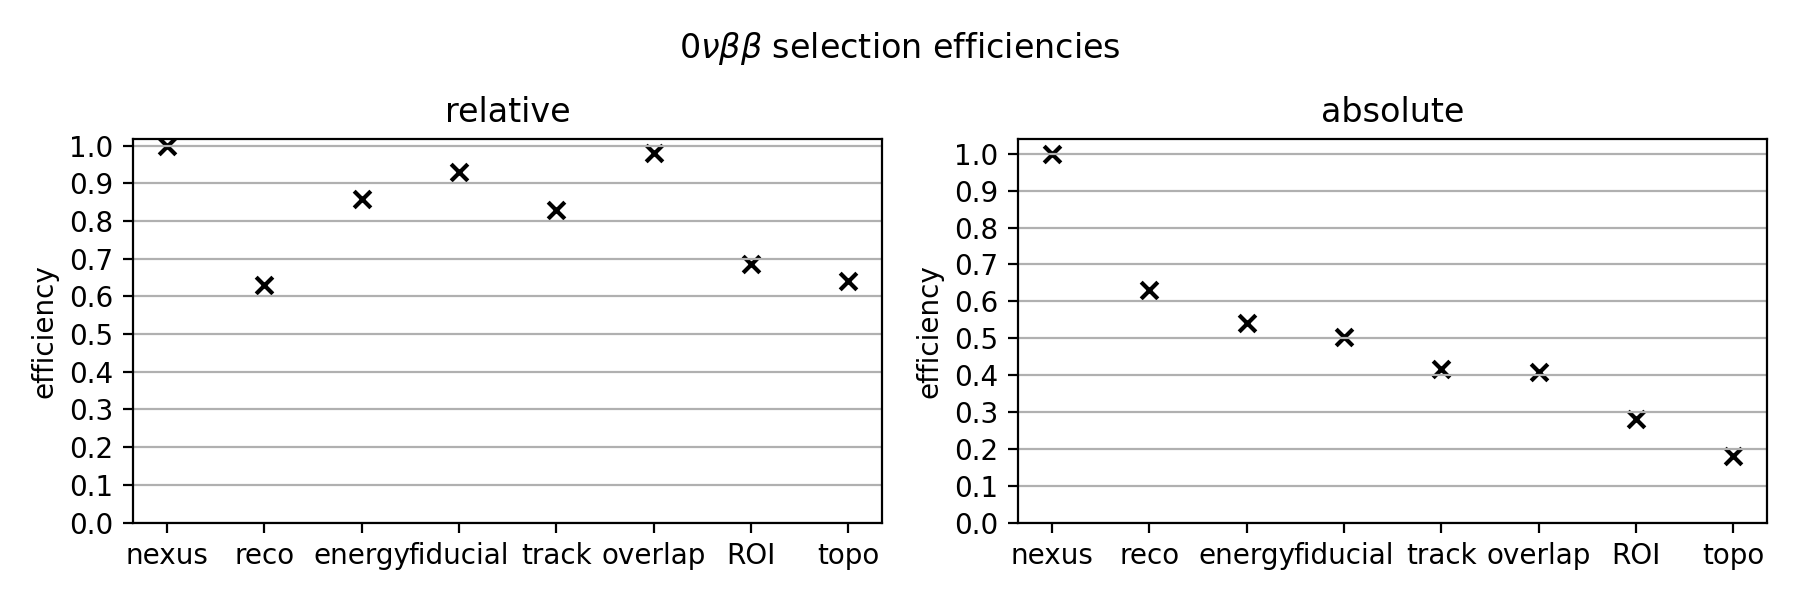

In [32]:
# signal
cuts = selections_df.columns
X = range(len(selections_df.columns))

a = selections_df.loc["0nubb"].values

plt.figure(figsize=[9, 3])
plt.suptitle(r"0$\nu\beta\beta$ selection efficiencies", y=0.95)

plt.subplot(121)
plt.title("relative")
plt.scatter(X[1:], a[1:] / a[:-1], marker="x", color="k", label=r"0$\nu\beta\beta$")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency")

plt.subplot(122)
plt.title("absolute")
plt.scatter(X[1:], a[1:] / a[0], marker="x", color="k", label=r"0$\nu\beta\beta$")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency")
plt.tight_layout();

<IPython.core.display.Javascript object>


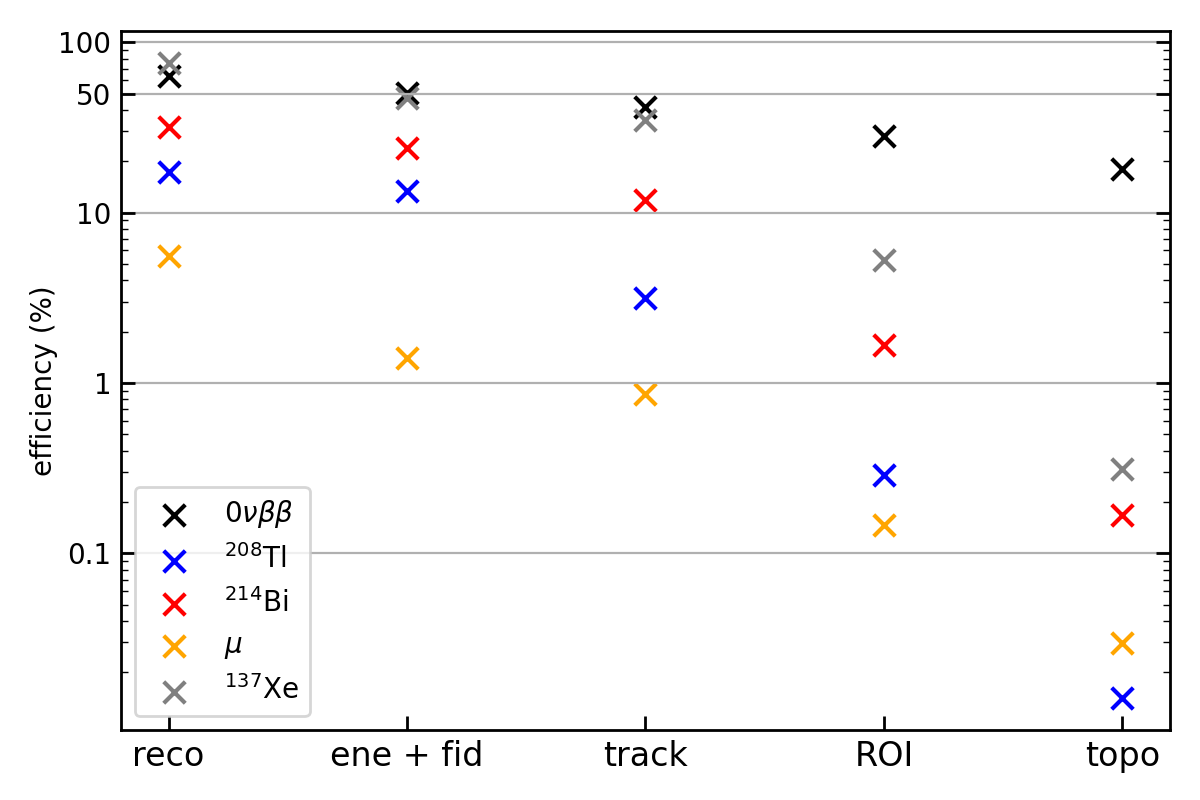

In [33]:
cuts = ["nexus", "reco", "fiducial", "track", "ROI", "topo"]

X = range(len(cuts))
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot(111)

# ax.set_title("signal selection efficiencies (E $\in$ [2.40, 2.50] MeV)")

s = 60

# 0nubb
a = selections_df.loc["0nubb", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="k", label=r"$0\nu\beta\beta$", s=s)
# 208Tl
a = selections_df.loc["208Tl", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="b", label=r"$^{208}$Tl", s=s)
# 214Bi
a = selections_df.loc["214Bi", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="r", label=r"$^{214}$Bi", s=s)
# muon
a = selections_df.loc["muons", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="orange", label=r"$\mu$", s=s)
# 137Xe
a = selections_df.loc["137Xe", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="grey", label=r"$^{137}$Xe", s=s)

ax.legend(loc="lower left")

# yaxis
ax.grid(axis="y")
ax.set_yscale("log")
yticks = [1e-3, 1e-2, 1e-1, 5e-1, 1]
yticks = [0.1, 1, 10, 50, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.set_xticks(X[1:])
cuts[2] = "ene + fid"
ax.set_xticklabels(cuts[1:], fontsize=12)
ax.set_ylabel("efficiency (%)", labelpad=0)

# TICKS
ax.set_frame_on(True)
ax.tick_params(axis="x", which="both", direction="in", length=5, width=1,
               bottom=True, top=False, left=False, right=False,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="y", which="major", direction="in", length=5, width=1,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
# ax.minorticks_on()
ax.tick_params(axis="y", which="minor", direction="in", length=2.5, width=0.5,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.spines["top"]   .set_linewidth(1)
ax.spines["left"]  .set_linewidth(1)
ax.spines["right"] .set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

fig.tight_layout();

In [31]:
selections_df

,nsim,nexus,reco,energy,fiducial,track,overlap,ROI,topo
Isotope,,,,,,,,,
0nubb,1.500000e+02,150.000000,94.590000,81.140000,75.45,62.54,61.39,46.7,NaN
137Xe,9.953959e+02,32.759153,24.935996,18.191013,15.349945,11.492019,11.45625,1.987726,NaN
208Tl,1.081847e+08,5519.941094,1016.098278,914.003308,798.135969,220.263605,219.469685,26.568589,NaN
214Bi,3.363642e+08,332.833198,108.943843,90.638834,84.429518,40.785362,40.635875,9.324553,NaN
muons,2.510456e+07,900.393054,49.993942,14.937214,12.659872,7.728619,7.692755,1.47041,NaN


<IPython.core.display.Javascript object>


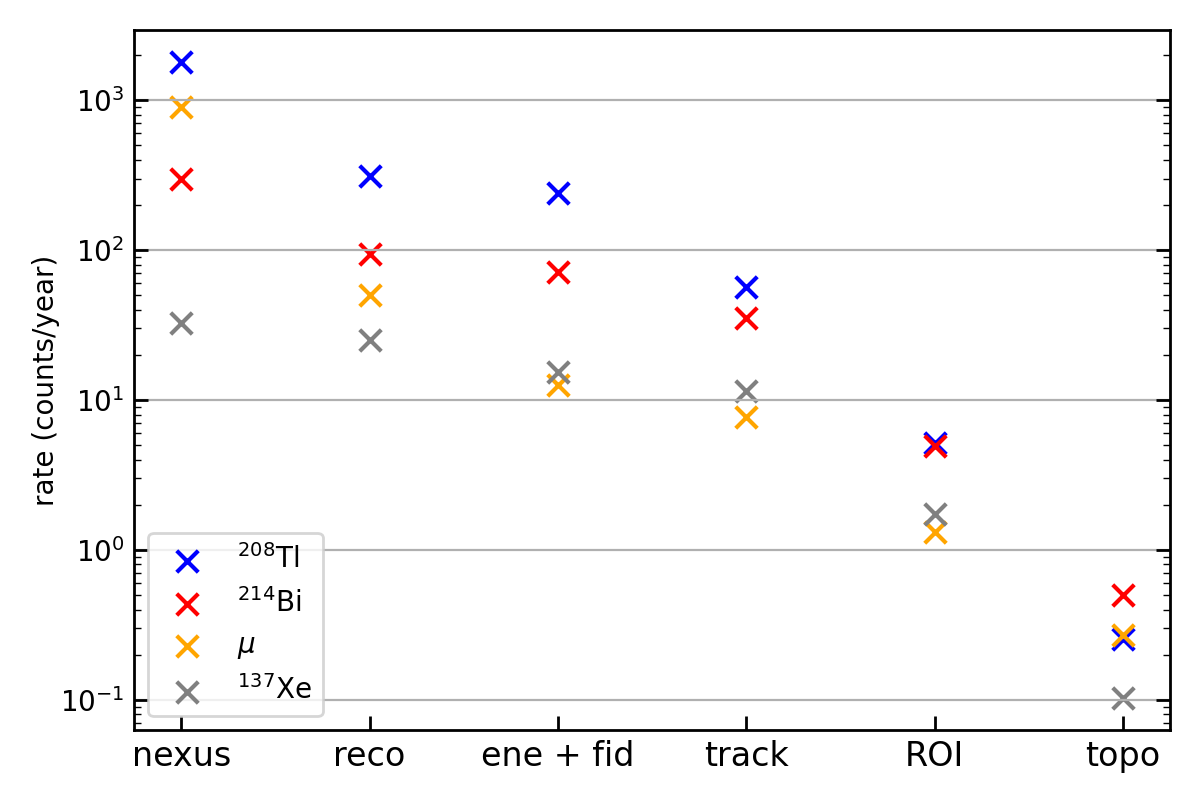

In [35]:
cuts = ["nexus", "reco", "fiducial", "track", "ROI", "topo"]

X = range(len(cuts))
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot(111)

# ax.set_title("background rates after selections")

s = 60

# # 0nubb
# a = selections_df.loc["0nubb", cuts].values
# ax.scatter(X, a, marker="x", color="k", label=r"$0\nu\beta\beta$")
# 208Tl
a = selections_df.loc["208Tl", cuts].values
ax.scatter(X, a, marker="x", color="b", label=r"$^{208}$Tl", s=s)
# 214Bi
a = selections_df.loc["214Bi", cuts].values
ax.scatter(X, a, marker="x", color="r", label=r"$^{214}$Bi", s=s)
# muon
a = selections_df.loc["muons", cuts].values
ax.scatter(X, a, marker="x", color="orange", label=r"$\mu$", s=s)
# 137Xe
a = selections_df.loc["137Xe", cuts].values
ax.scatter(X, a, marker="x", color="grey", label=r"$^{137}$Xe", s=s)

ax.legend(loc="lower left")

# yaxis
ax.grid(axis="y")
ax.set_yscale("log")

ax.set_xticks(X)
cuts[2] = "ene + fid"
ax.set_xticklabels(cuts, fontsize=12)
ax.set_ylabel("rate (counts/year)", labelpad=0)

# TICKS
ax.set_frame_on(True)
ax.tick_params(axis="x", which="both", direction="in", length=5, width=1,
               bottom=True, top=False, left=False, right=False,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="y", which="major", direction="in", length=5, width=1,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
# ax.minorticks_on()
ax.tick_params(axis="y", which="minor", direction="in", length=2.5, width=0.5,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.spines["top"]   .set_linewidth(1)
ax.spines["left"]  .set_linewidth(1)
ax.spines["right"] .set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

fig.tight_layout();

In [38]:
# # rate per component
# rates = pd.DataFrame()
# r = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / eff_df.loc["214Bi"].exposure).to_frame()
# r.loc[:, "Isotope"] = "214Bi"
# rates = pd.concat([rates, r])
# r = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / eff_df.loc["208Tl"].exposure).to_frame()
# r.loc[:, "Isotope"] = "208Tl"
# rates = pd.concat([rates, r])
# r = (tracks_muons.loc[sel_muons].value_counts("G4Volume") / eff_df.loc["muons"].exposure).to_frame()
# r.loc[:, "Isotope"] = "muons"
# rates = pd.concat([rates, r])
# r = (tracks_137Xe.loc[sel_137Xe].value_counts("G4Volume") / eff_df.loc["137Xe"].exposure).to_frame()
# r.loc[:, "Isotope"] = "137Xe"
# rates = pd.concat([rates, r])
# rates = rates.rename({0: "rate"}, axis=1).fillna(0)
# rates = rates.reset_index().set_index(["Isotope", "G4Volume"])

rates = pd.DataFrame()
# rates["lo"] = selections_df_abs.drop("0nubb", level=0)[("rate", "lo")]
# rates["up"] = selections_df_abs.drop("0nubb", level=0)[("rate", "up")]
# rates["rate"] = (rates.lo + rates.up)/2.
rates = selections_df_abs.rate.to_frame()

In [39]:
# is upper limit?
rates.loc[:, "upperlim"] = False

rates.loc[("214Bi", "ICS")       , "upperlim"] = True
rates.loc[("214Bi", "FIELD_RING"), "upperlim"] = True
rates.loc[("214Bi", "SIPM_BOARD"), "upperlim"] = True
rates.loc[("214Bi", "VESSEL")    , "upperlim"] = True
rates.loc[("214Bi", "SHIELDING_LEAD"), "upperlim"] = True

rates.loc[("208Tl", "ICS")       , "upperlim"] = True
rates.loc[("208Tl", "FIELD_RING"), "upperlim"] = True
rates.loc[("208Tl", "SIPM_BOARD"), "upperlim"] = True
rates.loc[("208Tl", "VESSEL")    , "upperlim"] = True

rates.sort_index(inplace=True)

<IPython.core.display.Javascript object>


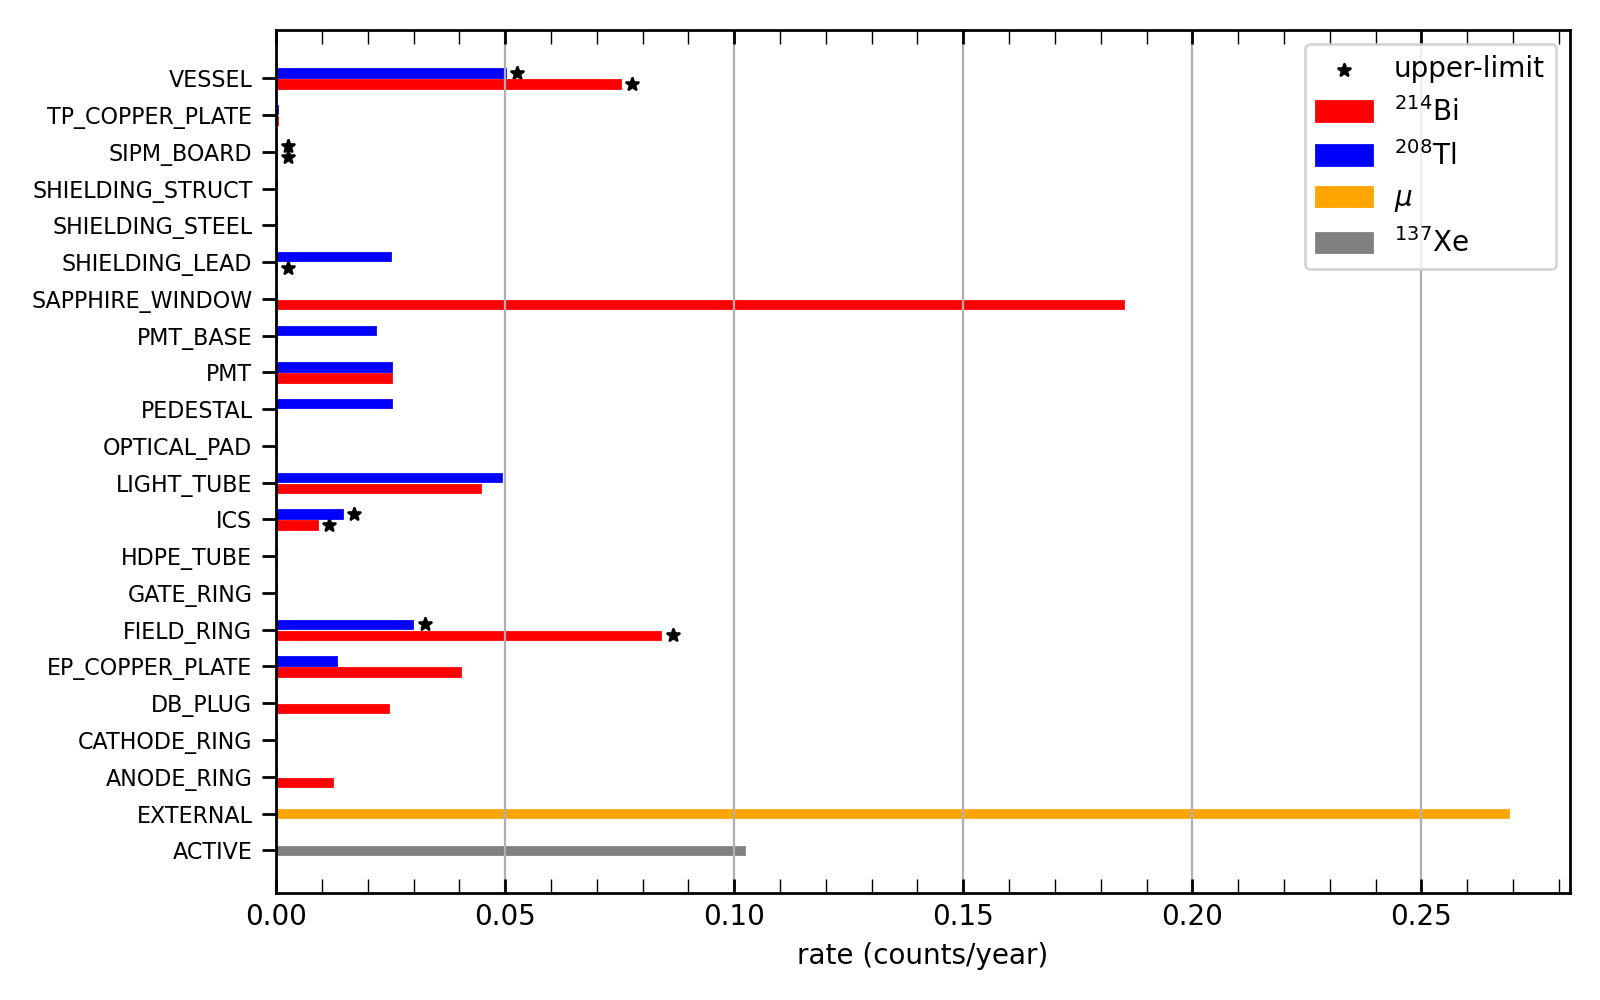

In [40]:
width = 2
dx = 10
volumes = rates.loc[["208Tl", "214Bi"]].index.get_level_values("G4Volume").unique().to_list()
X = np.arange(0, dx*len(volumes), dx)
tick_width = 1

fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

du = rates.drop("0nubb").rate.max()*0.01

# 214Bi
color="r"
s = rates.loc["214Bi"]
b1 = ax.barh( X-width/2.-tick_width/2., s.rate, height=width
             , color=color, edgecolor=color, label=r"$^{214}$Bi")
# ax.errorbar( s.rate, X-width/2.-tick_width/2., color=color, fmt="none"
#            , xerr = (s.rate - s.lo, s.up - s.rate), capsize=width, label=r"$^{214}$Bi")
isupp = s.upperlim
ax.scatter( s.rate.loc[isupp] + du, X[isupp]-width/2.-tick_width/2, marker="*"
          , s=20, facecolor="k", edgecolor="k", label="upper-limit")

# 208Tl
color="b"
s = rates.loc["208Tl"]
b2 = ax.barh( X+width/2.+tick_width/2., s.rate, height=width
             , color=color, edgecolor=color, label=r"$^{208}$Tl")
# ax.errorbar( s.rate, X+width/2.+tick_width/2., color=color, fmt="none"
#            , xerr = (s.rate - s.lo, s.up - s.rate), capsize=width, label=r"$^{208}$Tl")
isupp = s.upperlim
ax.scatter( s.rate.loc[isupp] + du, X[isupp]+width/2.+tick_width/2, marker="*"
          , s=20, facecolor="k", edgecolor="k")

# muons
color="orange"
s = rates.loc["muons"]
b2 = ax.barh( X[0]-dx, s.rate, height=width
             , color=color, edgecolor=color, label=r"$\mu$")
# ax.errorbar( s.rate, X[0]-dx, color=color, fmt="none"
#            , xerr = (s.rate - s.lo, s.up - s.rate), capsize=width, label=r"$\mu$")

# 137Xe
color="grey"
s = rates.loc["137Xe"]
b2 = ax.barh( X[0]-2*dx, s.rate, height=width
             , color=color, edgecolor=color, label=r"$^{137}$Xe")
# ax.errorbar( s.rate, X[0]-2*dx, color=color, fmt="none"
#            , xerr = (s.rate - s.lo, s.up - s.rate), capsize=width, label=r"$^{137}$Xe")

# ticks
X = np.append(X, [X[0]-dx])
volumes.append("EXTERNAL")
X = np.append(X, [X[0]-2*dx])
volumes.append("ACTIVE")

ax.set_yticks(X)
ax.set_yticklabels(volumes, rotation=0, fontsize=8)
ax.tick_params(axis='y', width=tick_width)
ax.tick_params(axis='x', direction="in")
ax.ticklabel_format(axis="x", scilimits=(-2, 2))
ax.set_xlabel(r"rate (counts/year)")
ax.set_xlim([0, None])
ax.legend()

# TICKS
ax.set_frame_on(True)

ax.tick_params(axis="x", which="major", direction="in", length=5, width=1,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="y", which="major", direction="out", length=5, width=1,
               bottom=False, top=False, left=True, right=False,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.minorticks_on()
ax.tick_params(axis="x", which="minor", direction="in", length=5, width=0.5,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="y", which="minor", direction="in", length=5, width=0.5,
               bottom=False, top=False, left=False, right=False,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.spines["top"]   .set_linewidth(1)
ax.spines["left"]  .set_linewidth(1)
ax.spines["right"] .set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.grid(which="major", axis="x")
# ax.set_facecolor("aliceblue")
fig.tight_layout()

In [41]:
selections_df.drop(["0nubb", "muons"]).topo.sum()

0.8540283285536435

In [42]:
selections_df.topo/selections_df.nsim

Isotope
0nubb    0.179733
137Xe    0.000103
208Tl         0.0
214Bi         0.0
muons         0.0
dtype: object

In [57]:
(selections_df.drop(["0nubb", "muons"]).topo.sum()) / ((roi[-1] - roi[0])*(xenon_mass/kg))

0.7328979238174104

In [58]:
selections_df

,nsim,nexus,reco,energy,fiducial,track,overlap,ROI,topo
Isotope,,,,,,,,,
0nubb,1.500000e+02,150.000000,94.590000,81.140000,75.45,62.54,61.39,42.09,26.29
137Xe,9.953959e+02,32.759153,24.935996,18.191013,15.349945,11.492019,11.45625,1.737344,0.086867
208Tl,8.088674e+07,1799.915088,312.331583,277.360593,240.663951,56.546631,56.444848,5.183182,0.251971
214Bi,3.181783e+08,295.989891,93.796288,76.322450,71.220325,35.250239,35.011375,4.943257,0.499141
muons,2.510456e+07,900.393054,49.993942,14.937214,12.659872,7.728619,7.692755,1.326955,0.268977


In [34]:
columns = selections_df.columns.to_list()
backgrounds = ["137Xe", "muons", "214Bi", "208Tl"]

In [35]:
background_rates = selections_df.loc[backgrounds].sum(axis=0)
eb = background_rates[1:].values / background_rates[:-1].values
es = selections_df.loc[("0nubb")][1:].values / selections_df.loc[("0nubb")][:-1].values

In [36]:
foms = es / eb**0.5
foms

array([263.07806964429335, 1.4995915176767995, 0.9224115055255251,
       0.9926975281545933, 1.4940618112508046, 0.9833941415779066,
       2.026469021531959, 2.115748588090915], dtype=object)

### Energy resolution

In [382]:
from scipy.signal import find_peaks, peak_widths

In [383]:
signal = pdf_energy_0nubb.pdf(binc).numpy()

peaks, _ = find_peaks(signal)
fwhm, heigh, x1, x2 = peak_widths(signal, peaks, rel_height=0.5)

x_to_energy = lambda x: (binc[-1] - binc[0])/len(signal)*x + binc[0]
R = (x_to_energy(x2) - x_to_energy(x1)) / x_to_energy(peaks) * 100

print("Energy resolution FWHM (%)", R)

Energy resolution FWHM (%) [0.62197527]


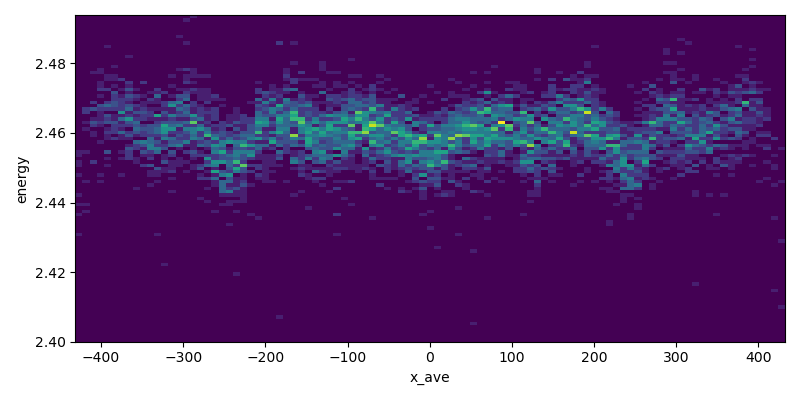

In [117]:
plt.figure(figsize=[8, 4])

xlabel = "x_ave"
ylabel = "energy"

x = tracks_0nubb.get(xlabel)
y = tracks_0nubb.get(ylabel)

xbins = np.linspace(x.min(), x.max(), 100)
ybins = np.linspace(2.4, y.max(), 100)

plt.hist2d( x, y, bins=[xbins, ybins])

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.tight_layout();

In [123]:
get_file_number = lambda filename: int(filename.split("/")[-1].split("_")[1])

path = os.path.expandvars("$HOME/NEXT/DATA/production/0nubb/ACTIVE/prod/isaura/")
filenames = sorted(glob.glob(os.path.join(path, "isaura_*.h5")), key=get_file_number)

In [124]:
energies = []

for i, filename in enumerate(filenames):
    proc = f"Processed {i} / {len(filenames)}"
    print(proc.ljust(100), end="\r")
    
    file = get_file_number(filename)
    hits = pd.read_hdf(filename, "MC/hits")
    
    es = hits.groupby("event_id").energy.sum().reset_index()
    es.loc[:, "file"] = file
    
    energies.extend(es.values)
    
energies = np.array(energies)    

In [70]:
import matplotlib
path = os.path.expandvars("$HOME/NEXT/DATA/production/0nubb/ACTIVE/prod/isaura/")
filenames = glob.glob(path + "isaura_*.h5")

In [71]:
tracks_0nubb_all = pd.DataFrame()

for filename in filenames:
    tracks = pd.read_hdf(filename, "Tracking/Tracks")
    tracks.loc[:, "file"] = get_file_number(filename)
    tracks.set_index(["event", "file"], inplace=True)
    tracks = remove_spurious_tracks(tracks, spurious_energy)
    
    tracks_0nubb_all = pd.concat([tracks_0nubb_all, tracks])

<IPython.core.display.Javascript object>


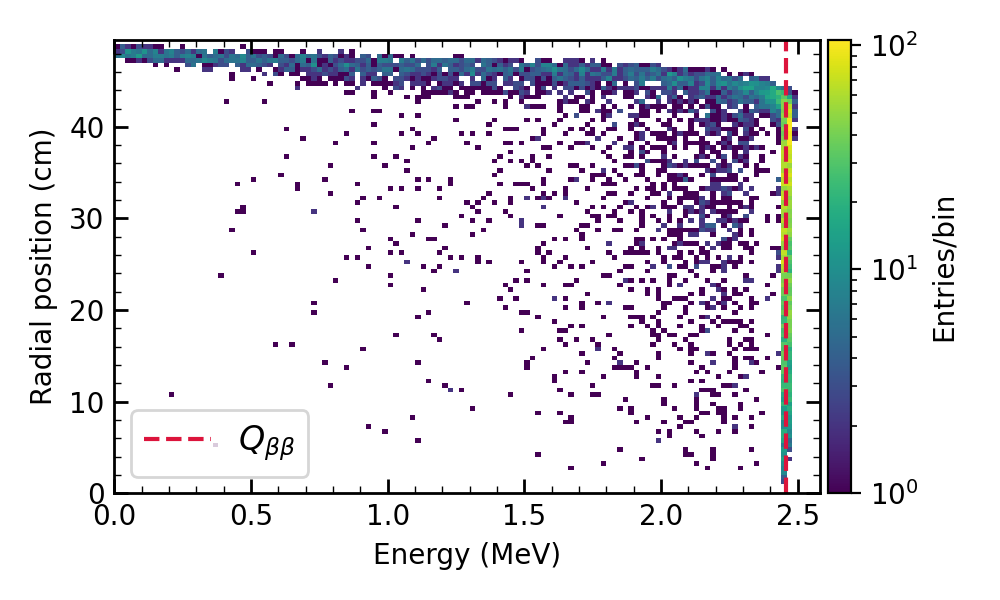

In [72]:
fig = plt.figure(figsize=[5, 3])
ax  = fig.add_subplot(111)

t = tracks_0nubb_all.loc[tracks_0nubb_all.numb_of_tracks == 1]


xbins = np.arange(0, 2.60, 0.02)
ybins = np.arange(0, 50, 0.5)

_, _ , _, mapp = ax.hist2d(t.energy, t.r_ave/10, bins=[xbins, ybins], norm=matplotlib.colors.LogNorm())
ax.axvline(2.458, color="crimson", label=r"$Q_{\beta\beta}$", linestyle="--")

ax.legend(fontsize=12, loc="lower left")
ax.set_xlabel("Energy (MeV)")
ax.set_ylabel("Radial position (cm)")

cbar = plt.colorbar(mapp, pad=0.01, label="Entries/bin")


# TICKS
ax.set_frame_on(True)
ax.tick_params(axis="both", which="major", direction="in", length=5, width=1,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.minorticks_on()
ax.tick_params(axis="both", which="minor", direction="in", length=2.5, width=0.5,
               bottom=True, top=True, left=True, right=True,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.spines["top"]   .set_linewidth(1)
ax.spines["left"]  .set_linewidth(1)
ax.spines["right"] .set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

fig.tight_layout()

In [77]:
get_file_number(filename)*np.ones(10, dtype=int)

array([266, 266, 266, 266, 266, 266, 266, 266, 266, 266])

In [86]:
pos    = []
energy = []
ids    = []
fnums  = []

for filename in filenames:
    hits = pd.read_hdf(filename, "MC/hits")
    
    fnumber  = get_file_number(filename)
    ids_     = hits.event_id.unique()
    energies = hits.groupby("event_id").energy.sum().values
    r        = hits.groupby("event_id").apply(lambda df: (((df.x * df.energy)**2 + (df.y * df.energy)**2)**0.5).sum()/df.energy.sum()).values
    
    fnums.extend(fnumber*np.ones(len(ids_), dtype=int))
    ids  .extend(ids_)
    pos  .extend(r)
    energy.extend(energies)
    
df = pd.DataFrame()
df["file"] = fnums
df["id"]   = ids
df["R"]    = pos
df["E"]    = energy

<IPython.core.display.Javascript object>


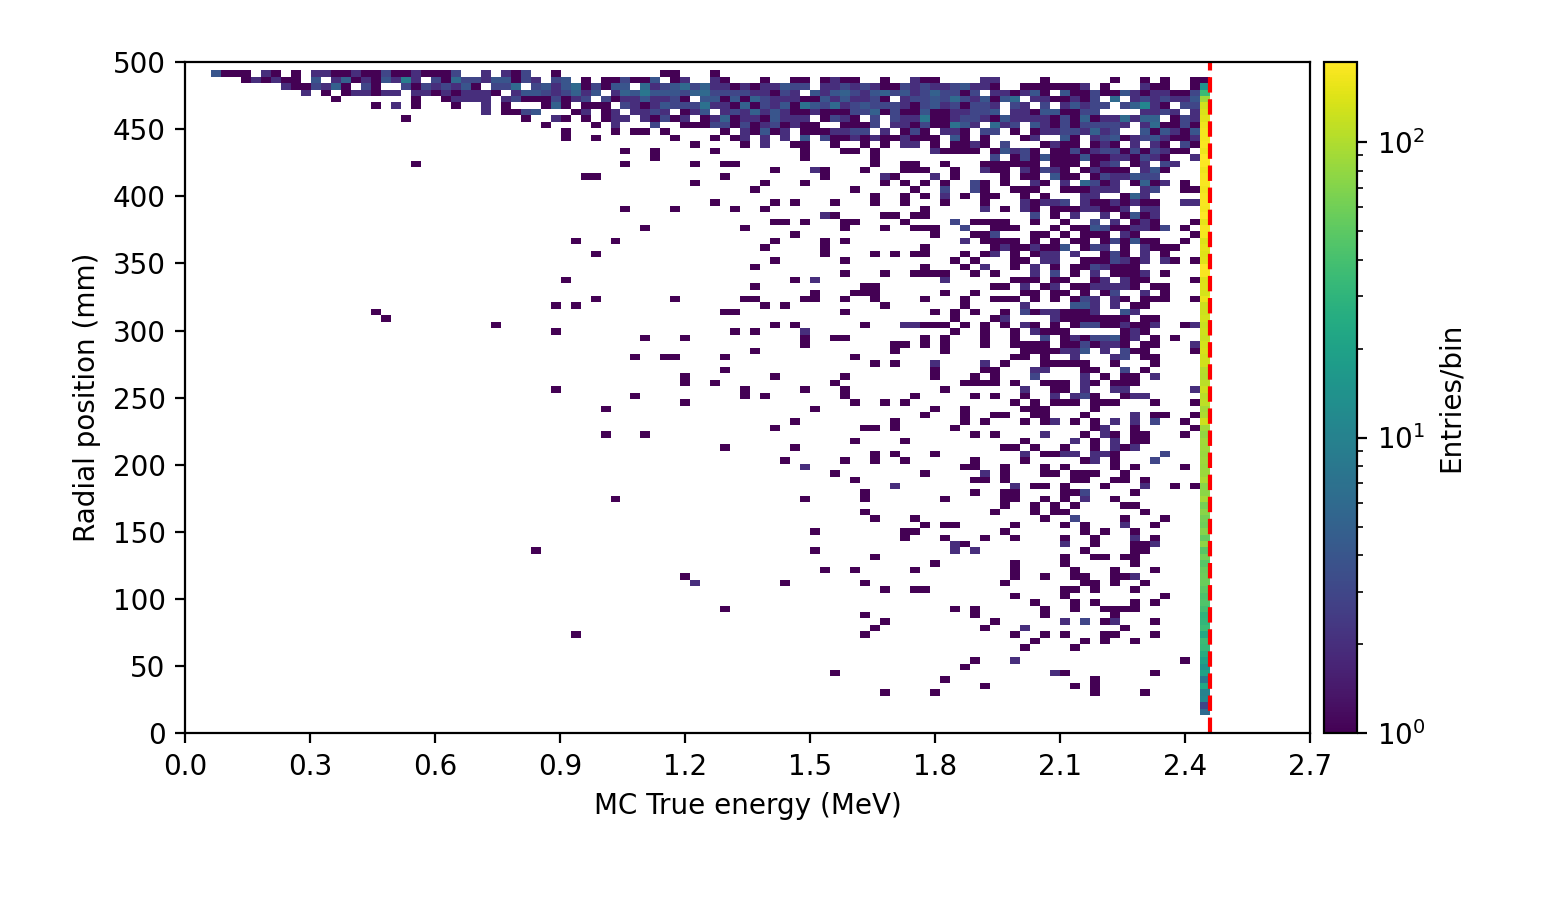

In [501]:
plt.figure(figsize=[6, 3])
# plt.hist(energy, bins=100)
_, _, _, mapp = plt.hist2d(df.E, df.R, bins=100, norm=matplotlib.colors.LogNorm())
plt.axvline(2.4578, linestyle="--", color="r", label=r"$Q_{\beta\beta}$")


cbar = plt.colorbar(mapp, pad=0.01, label="Entries/bin")

plt.xlim([None, 2.6])
plt.xticks(np.arange(0, 2.9, 0.3))
plt.yticks(np.arange(0, 550, 50))
plt.xlabel("MC True energy (MeV)")
plt.ylabel("Radial position (mm)")
# plt.ylim([400, None])
plt.tight_layout()

<IPython.core.display.Javascript object>


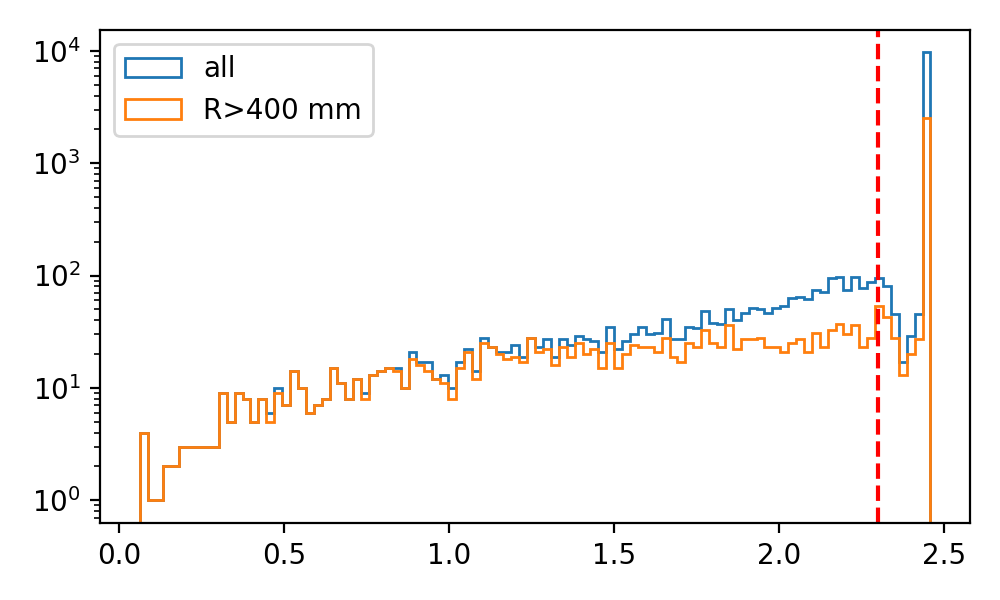

In [112]:
r = 400
plt.figure(figsize=[5, 3])
plt.hist(df.E        , bins=100, label=    "all", histtype="step")
plt.hist(df.E[df.R>r], bins=100, label=f"R>{r} mm", histtype="step")

plt.axvline(2.3, linestyle="--", color="r")

plt.yscale("log")
plt.legend()
plt.tight_layout()

In [476]:
out_events = df[(df.E < 2.3) & (df.R>400)]
sample = out_events.sample().iloc[0]
event = int(sample.id)
file  = int(sample.file)
print("event:", event)
print("file :", file)

event: 4430
file : 89


In [477]:
path = os.path.expandvars("$HOME/NEXT/DATA/production/0nubb/ACTIVE/prod/isaura/")
filename = path + f"isaura_{file}_0nubb.h5"
print(filename)

/Users/gonzalo/NEXT/DATA/production/0nubb/ACTIVE/prod/isaura/isaura_89_0nubb.h5


In [478]:
hits      = pd.read_hdf(filename, "MC/hits")     .set_index("event_id").loc[event]
particles = pd.read_hdf(filename, "MC/particles").set_index("event_id").loc[event]
if (particles.final_volume != "ACTIVE").any():
    print("Out")

xcm, ycm = (hits.x * hits.energy).sum() / hits.energy.sum(), (hits.y * hits.energy).sum() / hits.energy.sum()

Out


In [479]:
particles[particles.primary]["final_volume"]

event_id
4430              ACTIVE
4430    LIGHT_TUBE_DRIFT
Name: final_volume, dtype: object

<IPython.core.display.Javascript object>


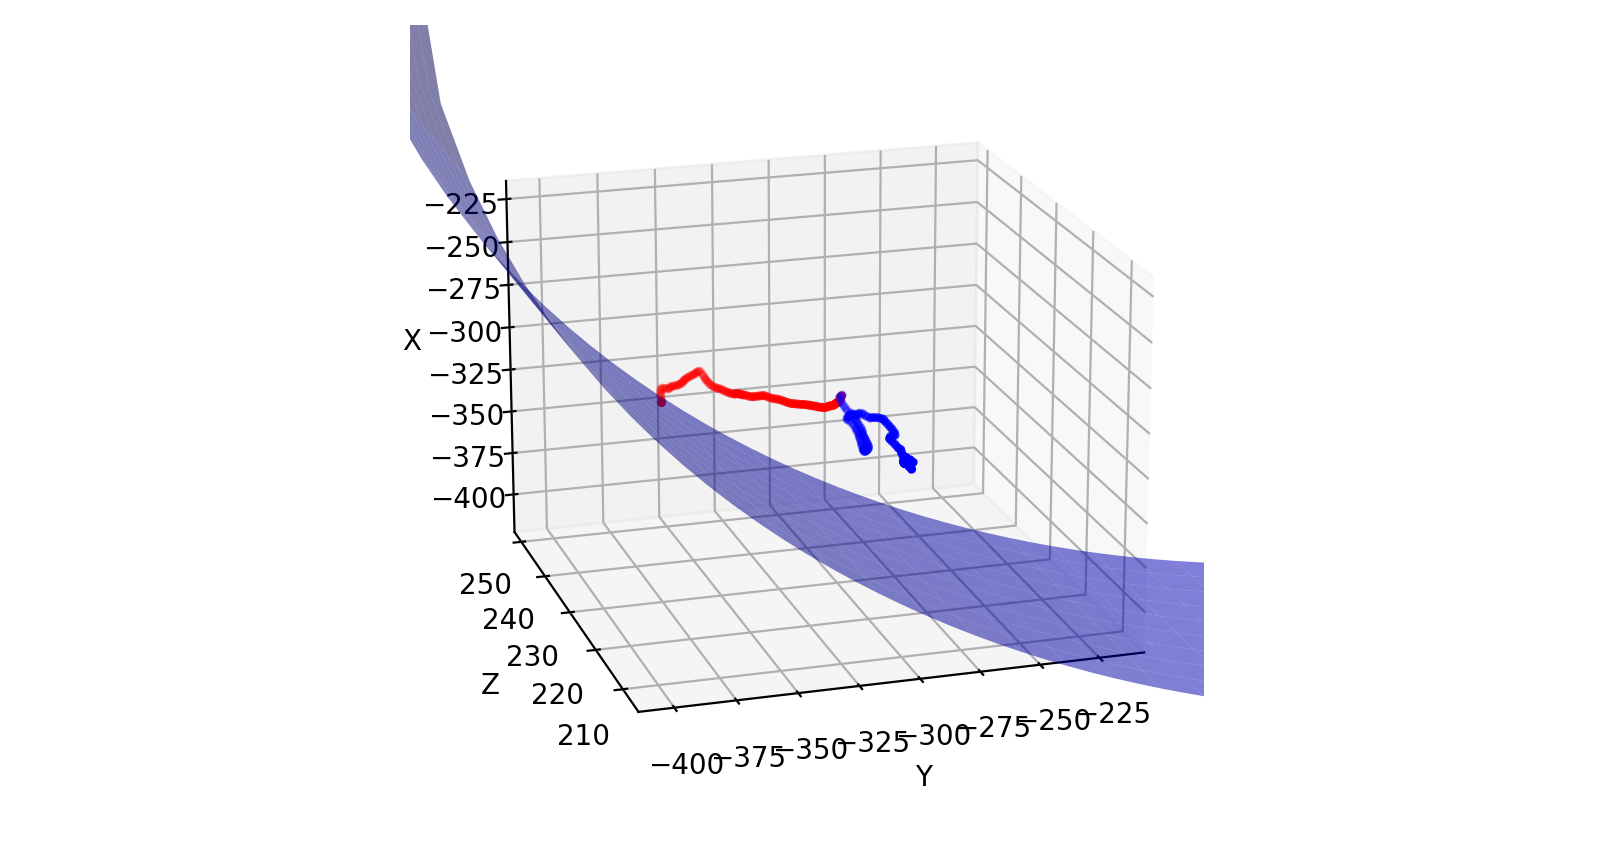

In [483]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_subplot(111, projection='3d')

sel = hits.particle_id==1
ax.scatter(hits[sel].y, hits[sel].z, hits[sel].x, color="r", s=5)
sel = hits.particle_id==2
ax.scatter(hits[sel].y, hits[sel].z, hits[sel].x, color="b", s=5)

R = 492
Y = np.linspace(-R, R, 100)
Z = np.linspace(hits.z.min(), hits.z.max(), 10)

Y, Z = np.meshgrid(Y, Z)
X = np.sqrt(R**2 - Y**2)

ax.plot_surface(Y, Z , X, color="b", alpha=0.5)
ax.plot_surface(Y, Z, -X, color="b", alpha=0.5)
# ax.plot_wireframe(Y, Z , X, color="b", alpha=0.5)
# ax.plot_wireframe(Y, Z, -X, color="b", alpha=0.5)

ax.set_zlim([xcm-100, xcm+100])
ax.set_xlim([ycm-100, ycm+100])

ax.set_xlabel("Y")
ax.set_ylabel("Z")
ax.set_zlabel("X")

fig.tight_layout()

In [85]:
# analysis cuts

emin, emax = 2.4, 2.5

sel = (tracks_0nubb.numb_of_tracks == 1) & (tracks_0nubb.energy.between(emin, emax)) & \
      (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max < zmax) & \
      (tracks_0nubb.ovlp_blob_energy == 0)
tbb = tracks_0nubb.loc[sel]

sel = (tracks_208Tl.numb_of_tracks == 1) & (tracks_208Tl.energy.between(emin, emax)) & \
      (tracks_208Tl.r_max < rmax) & (zmin<tracks_208Tl.z_min) & (tracks_208Tl.z_max < zmax) & \
      (tracks_208Tl.ovlp_blob_energy == 0)
ttl = tracks_208Tl.loc[sel]

sel = (tracks_214Bi.numb_of_tracks == 1) & (tracks_214Bi.energy.between(emin, emax)) & \
      (tracks_214Bi.r_max < rmax) & (zmin<tracks_214Bi.z_min) & (tracks_214Bi.z_max < zmax) & \
      (tracks_214Bi.ovlp_blob_energy == 0)
tbi = tracks_214Bi.loc[sel]

sel = (tracks_137Xe.numb_of_tracks == 1) & (tracks_137Xe.energy.between(emin, emax)) & \
      (tracks_137Xe.r_max < rmax) & (zmin<tracks_137Xe.z_min) & (tracks_137Xe.z_max < zmax) & \
      (tracks_137Xe.ovlp_blob_energy == 0)
txe = tracks_137Xe.loc[sel]

sel = (tracks_muons.numb_of_tracks == 1) & (tracks_muons.energy.between(emin, emax)) & \
      (tracks_muons.r_max < rmax) & (zmin<tracks_muons.z_min) & (tracks_muons.z_max < zmax) & \
      (tracks_muons.ovlp_blob_energy == 0)
tmu = tracks_muons.loc[sel]

<IPython.core.display.Javascript object>


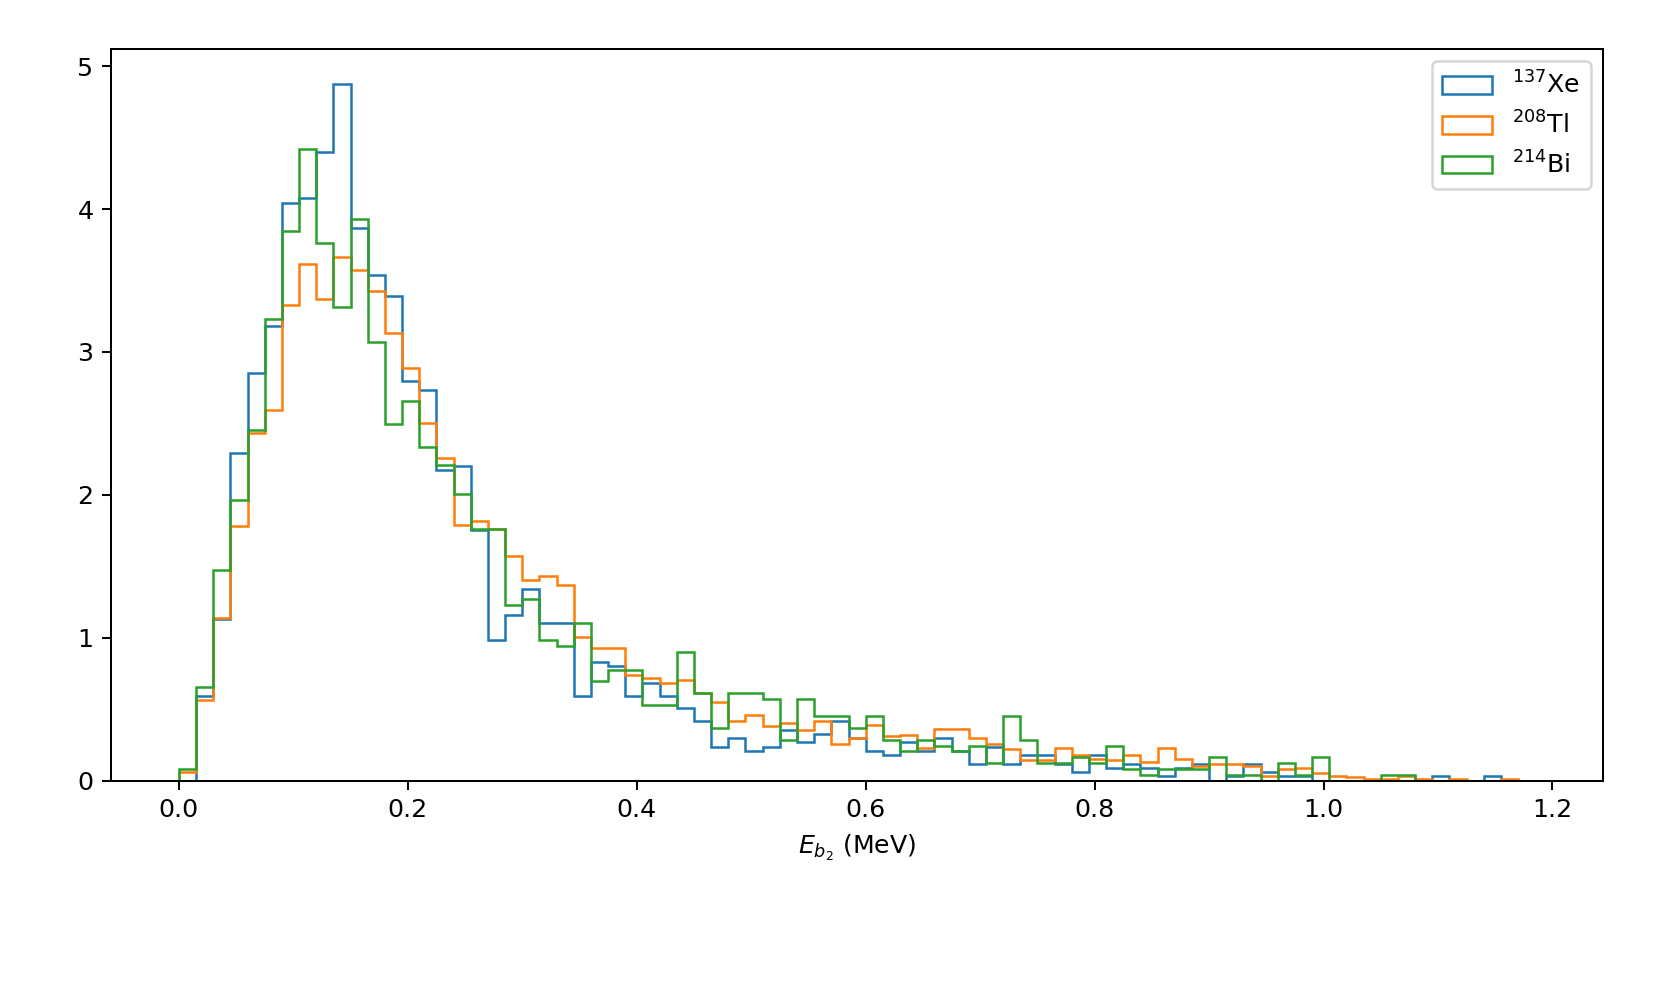

In [173]:
plt.figure(figsize=(5, 3))

# plt.hist2d(tbb.eblob2, tbb.energy, bins=100)
# plt.hist2d(txe.eblob2, txe.energy, bins=100)
# plt.hist2d(ttl.eblob2, ttl.energy, bins=100)
# plt.hist2d(tbi.eblob2, tbi.energy, bins=100)

bins = np.arange(0, 1.2, 0.01)
# plt.hist(txe.eblob2, bins=bins, histtype="step", density=True)
# plt.hist(ttl.eblob2, bins=bins, histtype="step", density=True)
# plt.hist(tbi.eblob2, bins=bins, histtype="step", density=True)

bins = np.arange(0, 1.2, 0.015)
# plt.hist(tbb.eblob2, bins=bins, histtype="step", density=True, label=r"$0\nu\beta\beta$")
plt.hist(txe.eblob2, bins=bins, histtype="step", density=True, label=r"$^{137}$Xe")
plt.hist(ttl.eblob2, bins=bins, histtype="step", density=True, label=r"$^{208}$Tl")
plt.hist(tbi.eblob2, bins=bins, histtype="step", density=True, label=r"$^{214}$Bi")
plt.xlabel(r"$E_{b_2}$ (MeV)")

plt.legend()
plt.tight_layout()

In [146]:
sel = (ttl.eblob2 > Eb2)
print(np.sum(sel) / len(sel))

sel = (tbi.eblob2 > Eb2)
print(np.sum(sel) / len(sel))

sel = (txe.eblob2 > Eb2)
print(np.sum(sel) / len(sel))

0.0996163332419841
0.09637814610190301
0.07091882247992863


In [147]:
N = txe.energy.between(*roi).sum()
n = ((txe.energy.between(*roi)) & (txe.eblob2>Eb2)).sum()

n/N

0.05912596401028278

In [148]:
N = tbi.energy.between(*roi).sum()
n = ((tbi.energy.between(*roi)) & (tbi.eblob2>Eb2)).sum()

n/N

0.12032085561497326

$S(T^{0\nu\beta\beta}_{1/2}) > 1.8 \cdot 10^{25}$ years

$n_{\beta\beta} = 0 \rightarrow T^{0\nu\beta\beta}_{1/2} > 2.9 \cdot 10^{25}$ years